# Skin segmentation 

In this assignement you will train classifier to assign colors to skin or no skin classes. The data is taken from [Skin Segmentation Data Set](http://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) in the UCI Machine Learning repository.

The  data is in a plain text format and contains four columns. First three contain RGB color data  represented as integers in the range 0-255, and the last column is an integer label  with 1 representing skin and 2 representing no skin. This file we can load directly into a numpy array:

In [41]:
data = np.loadtxt('data/Skin_NonSkin.txt')

In [42]:
rgb  = data[:,:3]
lbl = data[:,3].astype('int32') # some function expect labels to be integers

We see that the classes are not balanced:

In [43]:
np.bincount(lbl)

array([     0,  50859, 194198], dtype=int64)

## Problem 1 

Compare the performance of the QuadraticDiscriminantAnalysis, LinearDiscriminativeAnalysis and NaiveBayes classifiers on this set. Use the `sklearn` library when needed. Compare the confusion matrices (tpr, fpr, tnr, fnr), precision and f1_ score and auc_score, as well ROC curves. Prepare a summary table with all the numerical scores one row per classifier on one column per metric (use pandas.DataFame). Plot all  ROC curves on the same plot and label them accordingly. Assume that skin is positive and non-skin negative. 

__Hint__ as you will be repeating this it's probably a good idea  to write a python function that does all the analysis. 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from IPython.display import display

def analize(cls, train_X, train_Y, test_X, test_Y):

    frames = [] 
    matrix = []
    fprss = []
    tprss = []
    thdss = []
   
    for c, name in cls:
        c.fit(train_X,train_Y)
                
        test_predicted = c.predict(test_X)        
        test_predicted_proba = c.predict_proba(test_X)[:,1]

        precision = precision_score(test_Y, test_predicted, pos_label=1, average='micro')
        f1 = f1_score(test_Y, test_predicted, pos_label=1, average='micro')

        fprs, tprs, thds = roc_curve(test_Y, test_predicted_proba, pos_label=1)
        auc = roc_auc_score(test_Y, test_predicted_proba)

        tnr, fpr, fnr, tpr = confusion_matrix(test_Y==1, test_predicted_proba>0.5, normalize='true').ravel()
        
        disp = pd.DataFrame({"real label 1 (positive)":  [tpr, fnr], "real label 2 (negative)":\
                             [fpr, tnr]}, index=["predicted label 1 (positive)","predicted label 2 (negative)"])
        
        matrix.append(disp)
        dataframe=pd.DataFrame({'tnr':[tnr],
                              'fnr':[fnr],
                              'fpr':[fpr],
                              'tpr':[tpr],
                              'precision' : [precision],
                              'f1' :[f1],
                              'auc' :[auc]
                               }, index=[name])
        
        fprss.append(fprs)
        tprss.append(tprs)
        thdss.append(thds)

        frames.append(dataframe)
    
    result = pd.concat(frames)
    
    return  result, matrix, fprss, tprss, thdss


print("DONE")

DONE


,tnr,fnr,fpr,tpr,precision,f1,auc
QDA,0.998808,0.075180,0.001192,0.924820,0.983563,0.983563,0.999695
LDA,0.937461,0.092213,0.062539,0.907787,0.931347,0.931347,0.945937
GaussianNB,0.971814,0.265309,0.028186,0.734691,0.922958,0.922958,0.942515


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for QDA [ 1->IS SKIN (true), 2->IS NOT SKIN (false)]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),0.92482,0.001192
predicted label 2 (negative),0.07518,0.998808


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for LDA [ 1->IS SKIN (true), 2->IS NOT SKIN (false)]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),0.907787,0.062539
predicted label 2 (negative),0.092213,0.937461


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for GaussianNB [ 1->IS SKIN (true), 2->IS NOT SKIN (false)]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),0.734691,0.028186
predicted label 2 (negative),0.265309,0.971814



----------------------------------------------------------------------------------


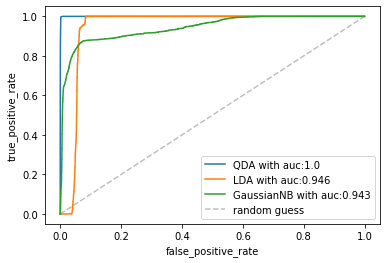

In [45]:
data = np.loadtxt('data/Skin_NonSkin.txt')

#Set aside 25% of data for testing!
seed = 77678
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25, random_state = seed)

#Find train and test datasets.
train_X = train_data[:,:3]
train_Y = train_data[:,3]

test_X = test_data[:,:3]
test_Y = test_data[:,3]

test_Y = np.where(test_Y == 2, 0, test_Y).astype('int32')
train_Y = np.where(train_Y == 2, 0, train_Y).astype('int32')


cls=[[QuadraticDiscriminantAnalysis(),"QDA"], [LinearDiscriminantAnalysis(),"LDA"], [GaussianNB(),"GaussianNB"]]


dataframe, matrix, fprss, tprss, thdss = analize(cls, train_X, train_Y, test_X, test_Y)
display(dataframe)


for i, cm in enumerate(matrix):    
    print("---------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------")
    print("confusion matrix for", cls[i][1], "[ 1->IS SKIN (true), 2->IS NOT SKIN (false)]")
    display(cm)

print("\n----------------------------------------------------------------------------------")
for i in range(len(fprss)):
    plt.plot(fprss[i], tprss[i], label=cls[i][1]+ " with auc:" + np.round(dataframe['auc'][i], decimals=3).astype('str'))
plt.plot([0,1],[0,1],'--',alpha=0.5, label='random guess', color='grey')
plt.legend()    
plt.ylabel('true_positive_rate')
plt.xlabel('false_positive_rate')
plt.show()

## Problem 2

Repeat same analysis but with RGB  data converted to Hue  Saturation Value (HSV) format. You can use the `colorsys` module for conversion 

In [46]:
from colorsys import rgb_to_hsv

def analize_hsv(cls, train_X, train_Y, test_X, test_Y):

    frames = [] 
    matrix = []
    fprss = []
    tprss = []
    thdss = []
   
    for c, name in cls:
        c.fit(train_X,train_Y)

        test_predicted = c.predict(test_X).astype("int32")
        test_predicted_proba = c.predict_proba(test_X)

        precision = precision_score(test_Y, test_predicted, pos_label=1, average='micro')
        f1 = f1_score(test_Y, test_predicted, pos_label=1, average='micro')

        fprs, tprs, thds = roc_curve(test_Y, test_predicted_proba[:,1], pos_label=1)
        auc = roc_auc_score(test_Y, test_predicted_proba[:,1])

        tnr, fpr, fnr, tpr = confusion_matrix(test_Y==1, test_predicted_proba[:,1]>0.5, normalize='true').ravel()
        
        disp = pd.DataFrame({"real label 1 (positive)":  [tpr, fnr], "real label 2 (negative)": [fpr, tnr]}, index=["predicted label 1 (positive)","predicted label 2 (negative)"])
        
        matrix.append(disp)
        dataframe=pd.DataFrame({'tnr':[tnr],
                              'fnr':[fnr],
                              'fpr':[fpr],
                              'tpr':[tpr],
                              'precision' : [precision],
                              'f1' :[f1],
                              'auc' :[auc]
                               }, index=[name])
        
        fprss.append(fprs)
        tprss.append(tprs)
        thdss.append(thds)

        frames.append(dataframe)
    
    result = pd.concat(frames)
    
    return  result, matrix, fprss, tprss, thdss


print("DONE")

DONE


,tnr,fnr,fpr,tpr,precision,f1,auc
QDA,0.994922,0.012279,0.005078,0.987721,0.993438,0.993438,0.999454
LDA,0.890465,0.000000,0.109535,1.000000,0.913034,0.913034,0.926413
GaussianNB,0.984869,0.004040,0.015131,0.995960,0.987154,0.987154,0.997195


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for QDA [ 2->IS NOT SKIN (false), 1->IS SKIN (true) ]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),0.987721,0.005078
predicted label 2 (negative),0.012279,0.994922


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for LDA [ 2->IS NOT SKIN (false), 1->IS SKIN (true) ]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),1.0,0.109535
predicted label 2 (negative),0.0,0.890465


---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
confusion matrix for GaussianNB [ 2->IS NOT SKIN (false), 1->IS SKIN (true) ]


,real label 1 (positive),real label 2 (negative)
predicted label 1 (positive),0.99596,0.015131
predicted label 2 (negative),0.00404,0.984869



----------------------------------------------------------------------------------


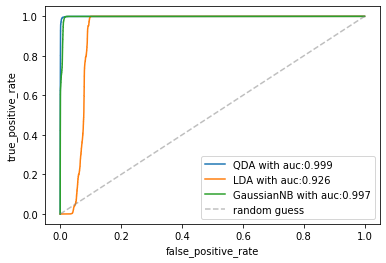

In [47]:
data = np.loadtxt('data/Skin_NonSkin.txt')

#Set aside 25% of data for testing!
seed = 77678
train_data, test_data = train_test_split(data, train_size=0.75, test_size=0.25, random_state = seed)

#Find train and test datasets.
train_X = np.asarray([rgb_to_hsv(*row) for row in train_data[:,:3]]) #inneficient but it does not matter
train_Y = train_data[:,3].astype('int32')

test_X = np.asarray([rgb_to_hsv(*row) for row in test_data[:,:3]]) #inneficient but it does not matter
test_Y = test_data[:,3].astype('int32')

test_Y = np.where(test_Y == 2, 0, test_Y).astype('int32')
train_Y = np.where(train_Y == 2, 0, train_Y).astype('int32')

cls=[[QuadraticDiscriminantAnalysis(),"QDA"], [LinearDiscriminantAnalysis(),"LDA"], [GaussianNB(),"GaussianNB"]]

dataframe, matrix, fprss, tprss, thdss = analize_hsv(cls, train_X, train_Y, test_X, test_Y)
display(dataframe)


for i, cm in enumerate(matrix):    
    print("---------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------")
    print("confusion matrix for", cls[i][1], "[ 2->IS NOT SKIN (false), 1->IS SKIN (true) ]")
    display(cm)

print("\n----------------------------------------------------------------------------------")
for i in range(len(fprss)):
    plt.plot(fprss[i], tprss[i], label=cls[i][1]+ " with auc:" + np.round(dataframe['auc'][i], decimals=3).astype('str'))
plt.plot([0,1],[0,1],'--',alpha=0.5, label='random guess', color='grey')  
plt.legend()
plt.ylabel('true_positive_rate')
plt.xlabel('false_positive_rate')
plt.show()